In [2]:
!pip install opendatasets scikit-learn

import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


In [6]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip

!unzip -q GTSRB_Final_Training_Images.zip
!unzip -q GTSRB_Final_Test_Images.zip
!unzip -q GTSRB_Final_Test_GT.zip

data_dir = '/content'
train_path = os.path.join(data_dir, 'GTSRB/Final_Training/Images')
test_path = os.path.join(data_dir, 'GTSRB/Final_Test/Images')

print("Dataset downloaded successfully!")

--2025-09-04 09:08:45--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  29.3MB/s    in 9.8s    

2025-09-04 09:08:56 (26.9 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]

--2025-09-04 09:08:56--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88978620 (85M) [application/zip]
Saving to: ‘GTSRB_Final_Test_Images.zip’

GTSRB_Final_Test_Im 100%[===================>]  84.8

In [7]:
class_names = {
    0: 'Speed limit (20km/h)', 1: 'Speed limit (30km/h)', 2: 'Speed limit (50km/h)',
    3: 'Speed limit (60km/h)', 4: 'Speed limit (70km/h)', 5: 'Speed limit (80km/h)',
    6: 'End of speed limit (80km/h)', 7: 'Speed limit (100km/h)', 8: 'Speed limit (120km/h)',
    9: 'No passing', 10: 'No passing for vehicles over 3.5 metric tons',
    11: 'Right-of-way at the next intersection', 12: 'Priority road', 13: 'Yield',
    14: 'Stop', 15: 'No vehicles', 16: 'Vehicles over 3.5 metric tons prohibited',
    17: 'No entry', 18: 'General caution', 19: 'Dangerous curve to the left',
    20: 'Dangerous curve to the right', 21: 'Double curve', 22: 'Bumpy road',
    23: 'Slippery road', 24: 'Road narrows on the right', 25: 'Road work',
    26: 'Traffic signals', 27: 'Pedestrians', 28: 'Children crossing',
    29: 'Bicycles crossing', 30: 'Beware of ice/snow', 31: 'Wild animals crossing',
    32: 'End of all speed and passing limits', 33: 'Turn right ahead',
    34: 'Turn left ahead', 35: 'Ahead only', 36: 'Go straight or right',
    37: 'Go straight or left', 38: 'Keep right', 39: 'Keep left',
    40: 'Roundabout mandatory', 41: 'End of no passing',
    42: 'End of no passing by vehicles over 3.5 metric tons'
}
num_classes = len(class_names)

print(f"Number of classes: {num_classes}")
print("Sample class names:")
for i in range(10):
    print(f"{i}: {class_names[i]}")
def count_images(path):
    count = 0
    for root, dirs, files in os.walk(path):
        count += len([f for f in files if f.endswith('.ppm')])
    return count

train_count = count_images(train_path)
test_count = count_images(test_path)

print(f"Training images: {train_count}")
print(f"Test images: {test_count}")

Number of classes: 43
Sample class names:
0: Speed limit (20km/h)
1: Speed limit (30km/h)
2: Speed limit (50km/h)
3: Speed limit (60km/h)
4: Speed limit (70km/h)
5: Speed limit (80km/h)
6: End of speed limit (80km/h)
7: Speed limit (100km/h)
8: Speed limit (120km/h)
9: No passing
Training images: 39209
Test images: 12630


In [8]:
IMG_SIZE = 32

def preprocess_image(img_path):

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    return img

def load_data(data_path):
    images = []
    labels = []
    class_folders = os.listdir(data_path)

    for class_folder in class_folders:
        class_path = os.path.join(data_path, class_folder)
        if os.path.isdir(class_path):
            label = int(class_folder)
            for img_file in os.listdir(class_path):
                if img_file.endswith('.ppm'):
                    img_path = os.path.join(class_path, img_file)
                    img = preprocess_image(img_path)
                    images.append(img)
                    labels.append(label)

    return np.array(images), np.array(labels)

print("Preprocessing functions defined!")

Preprocessing functions defined!


In [9]:
print("Loading training data...")
X_train, y_train = load_data(train_path)
print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
y_train = keras.utils.to_categorical(y_train, num_classes)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=np.argmax(y_train, axis=1)
)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")

Loading training data...
Training data shape: (39209, 32, 32, 3)
Training labels shape: (39209,)
Training set: (31367, 32, 32, 3), (31367, 43)
Validation set: (7842, 32, 32, 3), (7842, 43)


In [10]:
print("Loading test data...")
test_df = pd.read_csv('/content/GT-final_test.csv', sep=';')
X_test = []
y_test = []

for _, row in test_df.iterrows():
    img_path = os.path.join(test_path, row['Filename'])
    img = preprocess_image(img_path)
    X_test.append(img)
    y_test.append(row['ClassId'])

X_test = np.array(X_test)
y_test = np.array(y_test)
y_test_categorical = keras.utils.to_categorical(y_test, num_classes)

print(f"Test data shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")

Loading test data...
Test data shape: (12630, 32, 32, 3)
Test labels shape: (12630,)


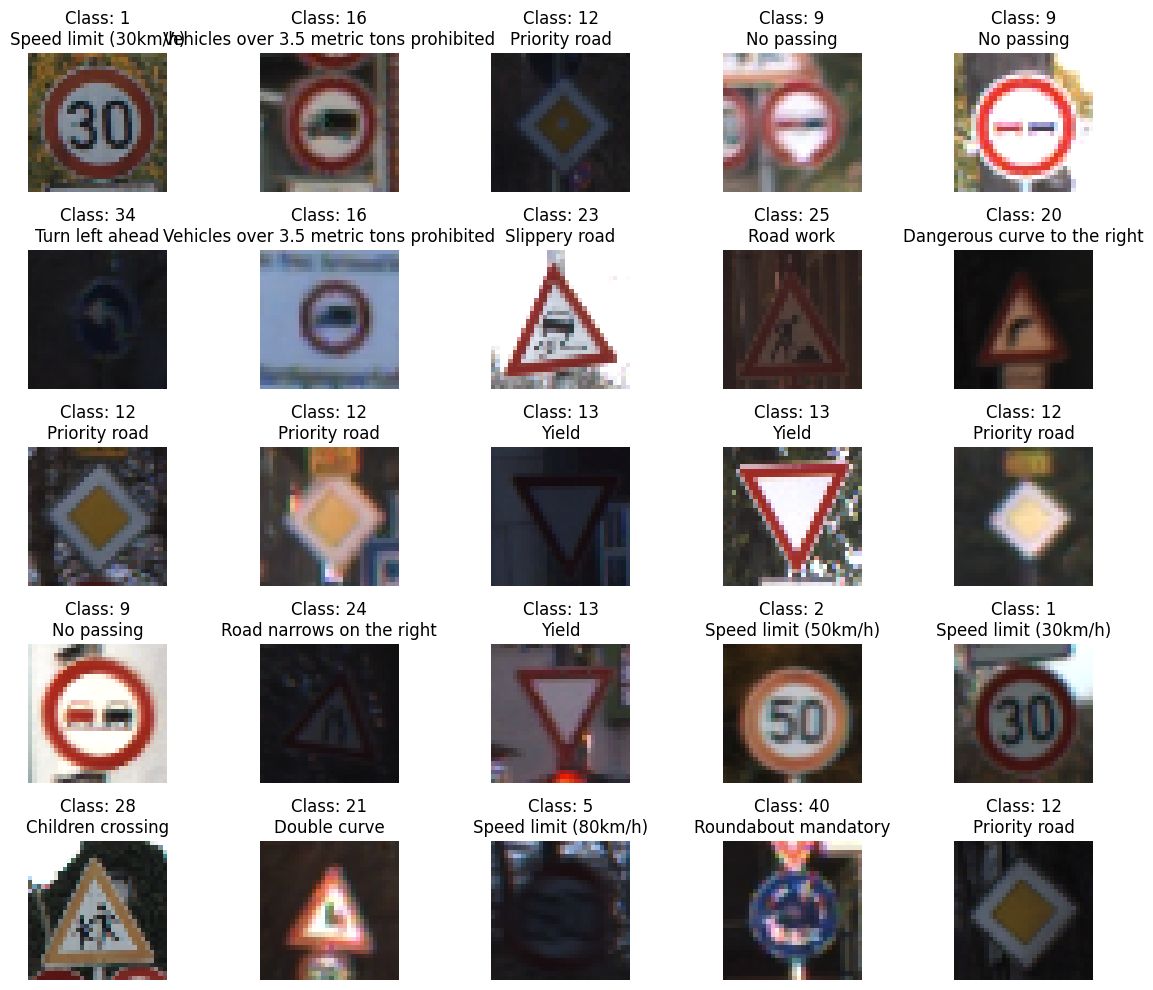

In [11]:
plt.figure(figsize=(12, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    idx = random.randint(0, len(X_train)-1)
    plt.imshow(X_train[idx])
    class_id = np.argmax(y_train[idx])
    plt.title(f"Class: {class_id}\n{class_names[class_id]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [12]:
datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    fill_mode='nearest'
)
datagen.fit(X_train)
print("Data augmentation configured!")

Data augmentation configured!


In [15]:
def create_custom_cnn():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3), padding='same'),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

custom_cnn = create_custom_cnn()
custom_cnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

custom_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 43)             │        22,059 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,361,099 (5.19 MB)

 Trainable params: 1,359,627 (5.19 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [19]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
batch_size = 32
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, verbose=1)

print("Starting training...")
history_custom = custom_cnn.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=5, #Reduced Epochs as its only testting
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

X_train shape: (31367, 32, 32, 3)
y_train shape: (31367, 43)
X_val shape: (7842, 32, 32, 3)
y_val shape: (7842, 43)
Starting training...
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 317s 324ms/step - accuracy: 0.9942 - loss: 0.0180 - val_accuracy: 0.9994 - val_loss: 0.0016 - learning_rate: 2.0000e-04
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9994 - val_loss: 0.0016 - learning_rate: 2.0000e-04
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 342s 305ms/step - accuracy: 0.9952 - loss: 0.0164 - val_accuracy: 0.9992 - val_loss: 0.0020 - learning_rate: 2.0000e-04
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 1.0000 - loss: 0.0172 - val_accuracy: 0.9992 - val_loss: 0.0020 - learning_rate: 2.0000e-04
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 302s 306ms/step - accuracy: 0.9964 - loss: 0.0113 - val_accuracy: 0.9997 - val_loss: 6.6714e-04 - learning_rate: 2.0000e-04
Restoring model weights from the end of the best epoch: 5.


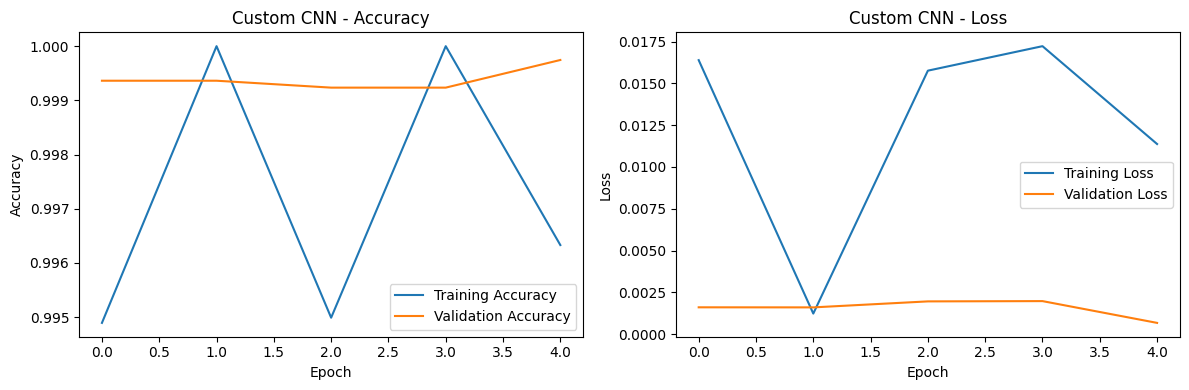

Custom CNN Test Accuracy: 0.9893


In [29]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_custom.history['accuracy'], label='Training Accuracy')
plt.plot(history_custom.history['val_accuracy'], label='Validation Accuracy')
plt.title('Custom CNN - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_custom.history['loss'], label='Training Loss')
plt.plot(history_custom.history['val_loss'], label='Validation Loss')
plt.title('Custom CNN - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()
test_loss, test_acc = custom_cnn.evaluate(X_test, y_test_categorical, verbose=0)
print(f"Custom CNN Test Accuracy: {test_acc:.4f}")

In [21]:
def create_mobilenet():
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    base_model.trainable = False

    model = Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

mobilenet = create_mobilenet()
mobilenet.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

mobilenet.summary()

/tmp/ipython-input-38774235.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1, 1, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,597,995 (9.91 MB)

 Trainable params: 339,499 (1.30 MB)

 Non-trainable params: 2,258,496 (8.62 MB)

In [23]:
history_mobilenet = mobilenet.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 60s 123ms/step - accuracy: 0.1647 - loss: 3.3017 - val_accuracy: 0.2989 - val_loss: 2.5120 - learning_rate: 0.0010
Epoch 2/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 56s 114ms/step - accuracy: 0.2482 - loss: 2.6254 - val_accuracy: 0.3182 - val_loss: 2.2903 - learning_rate: 0.0010
Epoch 3/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 59s 120ms/step - accuracy: 0.2780 - loss: 2.4671 - val_accuracy: 0.3301 - val_loss: 2.2428 - learning_rate: 0.0010
Epoch 4/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 58s 118ms/step - accuracy: 0.2768 - loss: 2.4353 - val_accuracy: 0.3349 - val_loss: 2.2036 - learning_rate: 0.0010
Epoch 5/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 60s 121ms/step - accuracy: 0.2891 - loss: 2.3836 - val_accuracy: 0.3447 - val_loss: 2.1743 - learning_rate: 0.0010
Epoch 6/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 56s 115ms/step - accuracy: 0.3032 - loss: 2.3299 - val_accuracy: 0.3472 - val_loss: 2.1494 - learning_rate: 0.0010
Epoch 7/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 57s 115ms/step - accuracy: 0.3

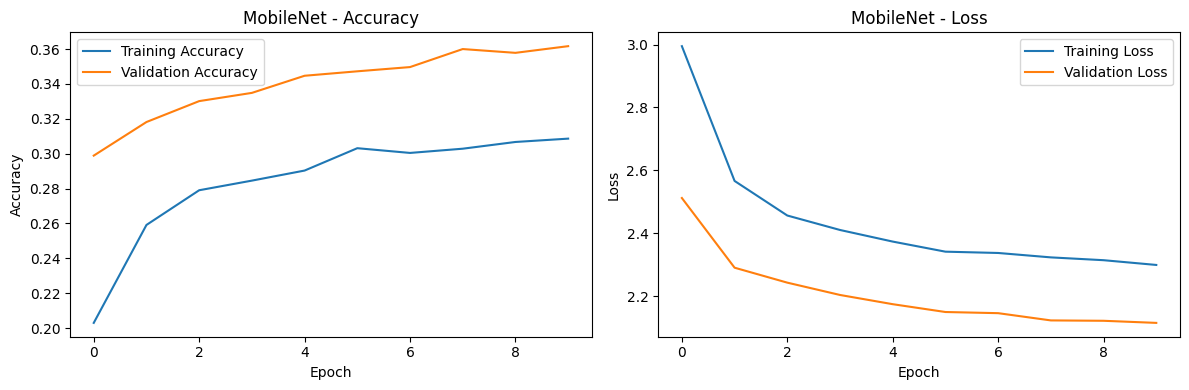

MobileNet Test Accuracy: 0.2885


In [24]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_mobilenet.history['accuracy'], label='Training Accuracy')
plt.plot(history_mobilenet.history['val_accuracy'], label='Validation Accuracy')
plt.title('MobileNet - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_mobilenet.history['loss'], label='Training Loss')
plt.plot(history_mobilenet.history['val_loss'], label='Validation Loss')
plt.title('MobileNet - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()
test_loss_mobile, test_acc_mobile = mobilenet.evaluate(X_test, y_test_categorical, verbose=0)
print(f"MobileNet Test Accuracy: {test_acc_mobile:.4f}")

In [25]:
print("Model Comparison:")
print(f"Custom CNN Test Accuracy: {test_acc:.4f}")
print(f"MobileNet Test Accuracy: {test_acc_mobile:.4f}")
y_pred_custom = custom_cnn.predict(X_test)
y_pred_mobile = mobilenet.predict(X_test)
y_pred_custom_classes = np.argmax(y_pred_custom, axis=1)
y_pred_mobile_classes = np.argmax(y_pred_mobile, axis=1)

Model Comparison:
Custom CNN Test Accuracy: 0.9893
MobileNet Test Accuracy: 0.2885
395/395 ━━━━━━━━━━━━━━━━━━━━ 27s 69ms/step
395/395 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step


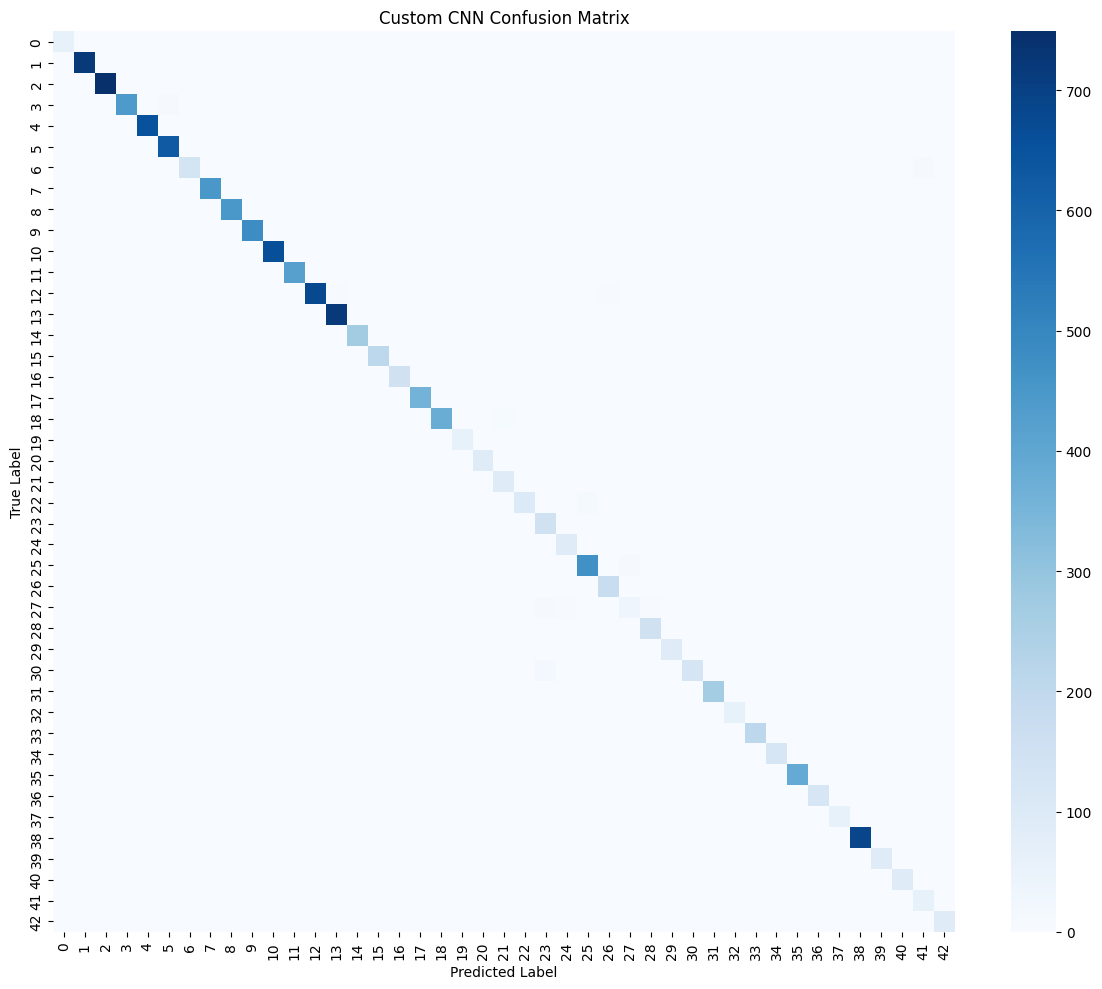

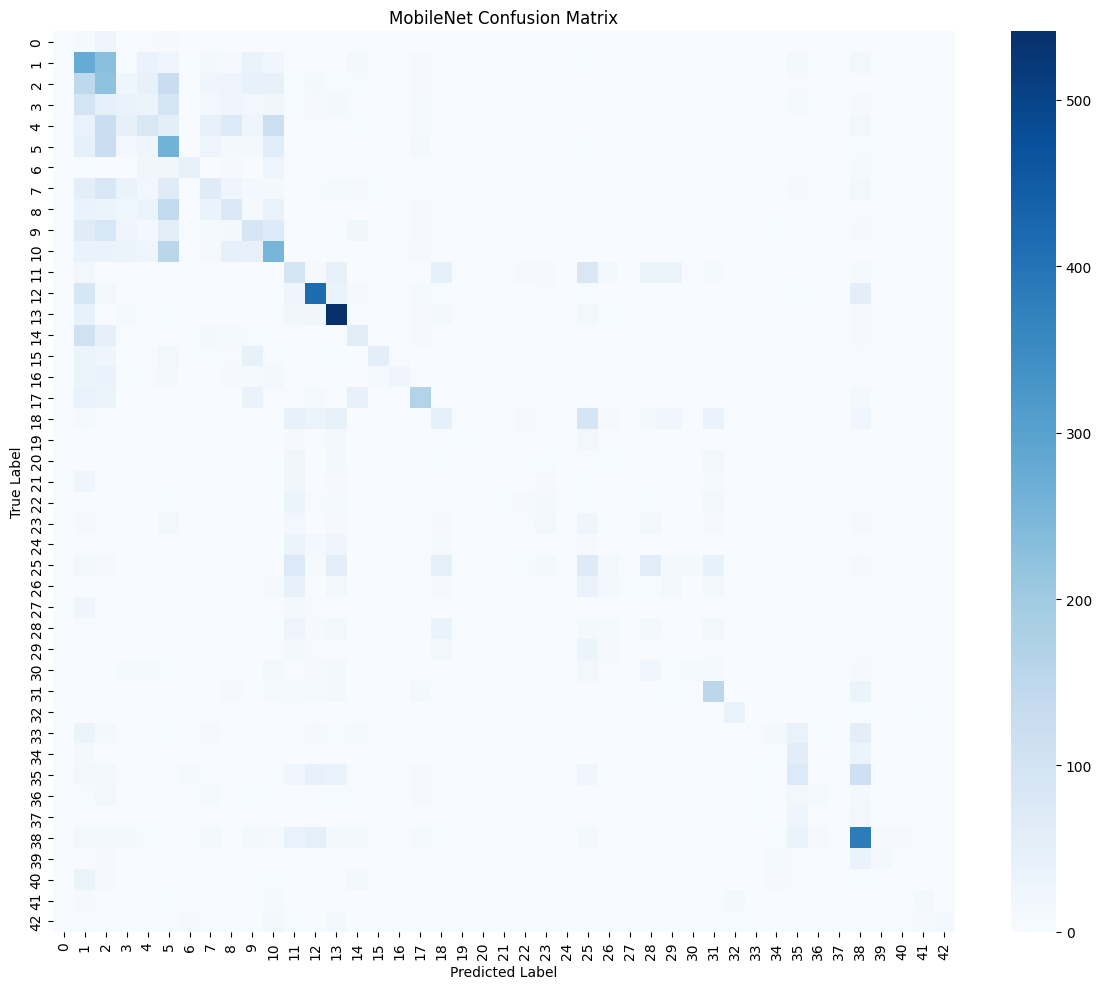

In [26]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
plot_confusion_matrix(y_test, y_pred_custom_classes, 'Custom CNN Confusion Matrix')
plot_confusion_matrix(y_test, y_pred_mobile_classes, 'MobileNet Confusion Matrix')

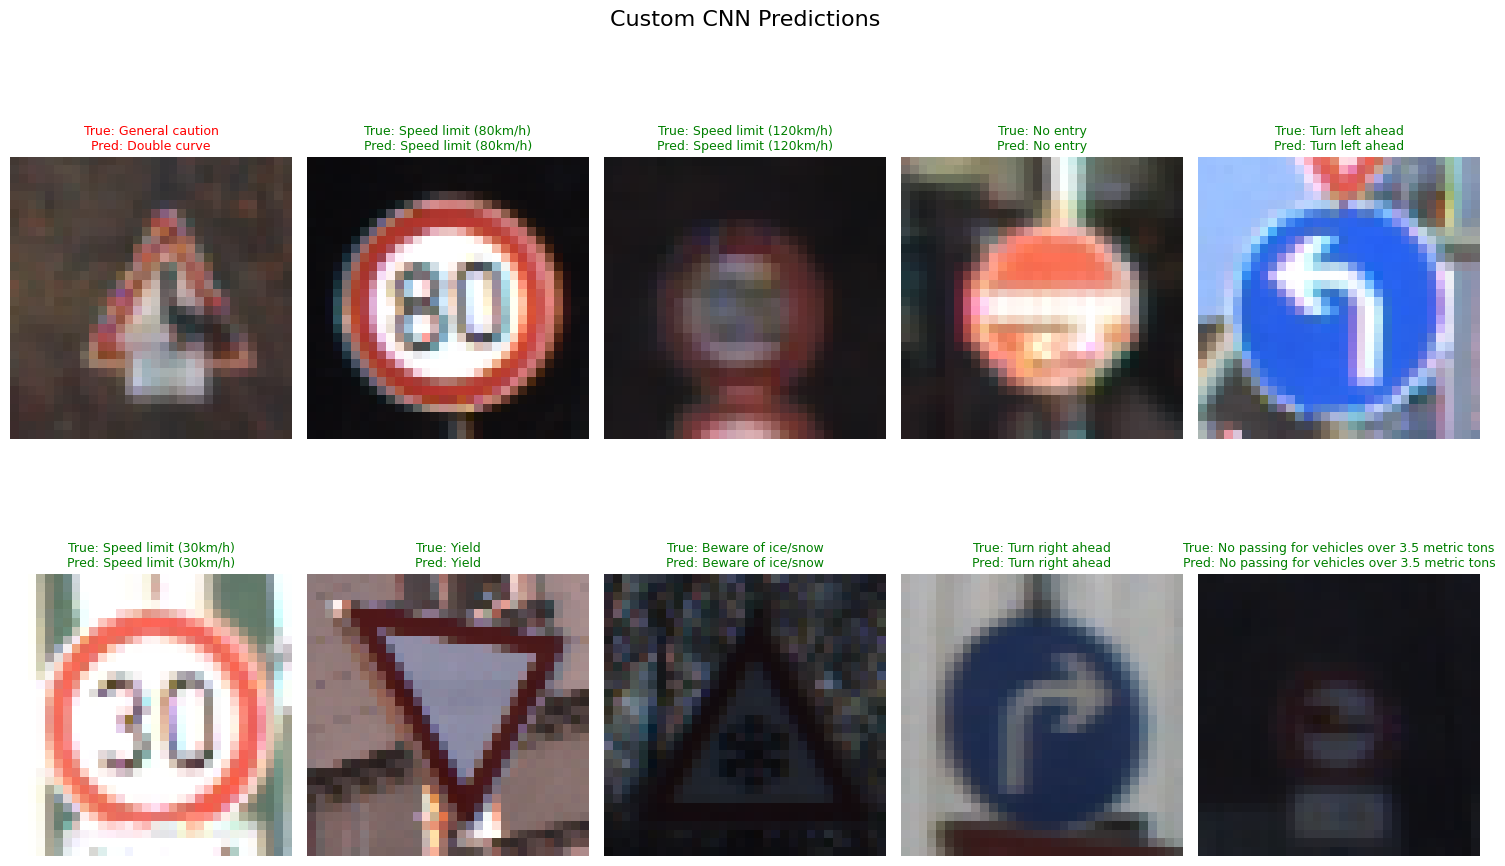

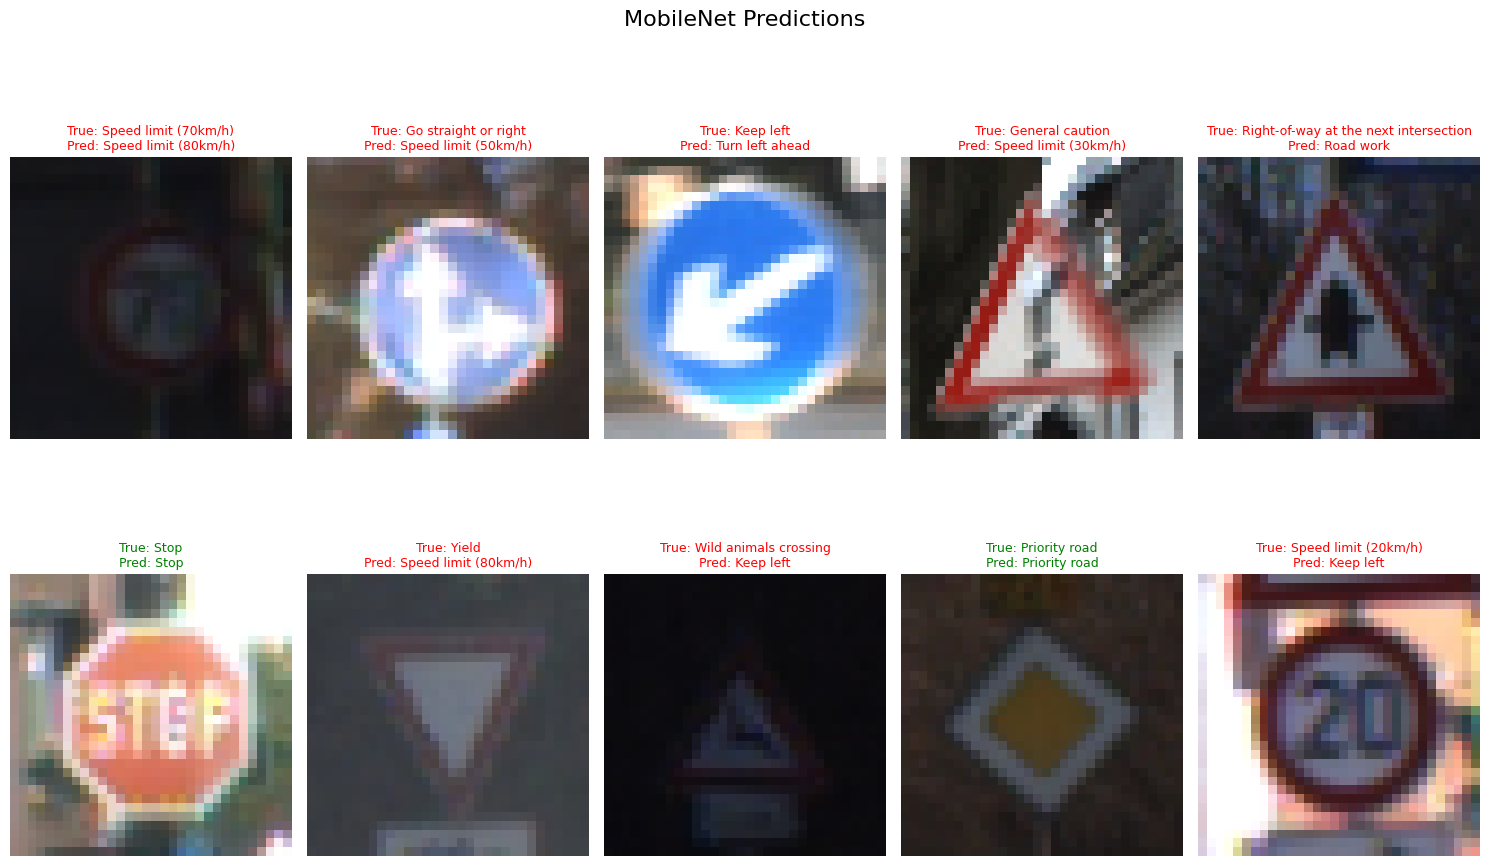

In [27]:
def plot_sample_predictions(images, true_labels, pred_labels, class_names, model_name, num_samples=10):
    plt.figure(figsize=(15, 10))
    indices = np.random.choice(range(len(images)), num_samples)

    for i, idx in enumerate(indices):
        plt.subplot(2, 5, i+1)
        plt.imshow(images[idx])

        true_class = class_names[true_labels[idx]]
        pred_class = class_names[pred_labels[idx]]

        color = 'green' if true_labels[idx] == pred_labels[idx] else 'red'
        plt.title(f"True: {true_class}\nPred: {pred_class}", color=color, fontsize=9)
        plt.axis('off')

    plt.suptitle(f'{model_name} Predictions', fontsize=16)
    plt.tight_layout()
    plt.show()
plot_sample_predictions(X_test, y_test, y_pred_custom_classes, class_names, 'Custom CNN')
plot_sample_predictions(X_test, y_test, y_pred_mobile_classes, class_names, 'MobileNet')

In [28]:
custom_cnn.save('traffic_sign_custom_cnn.h5')
mobilenet.save('traffic_sign_mobilenet.h5')
print("Models saved successfully!")

Models saved successfully!


#Traffic Sign Recognition System:

This project focused on building a system to automatically recognize traffic signs from images using deep learning. At first, it sounded straightforward — “just classify images into their corresponding signs” — but I quickly realized that the problem was more nuanced. Traffic signs can look very similar to each other, vary in size, color, or orientation, and some appear very rarely in the dataset, which made accurate classification challenging.

I used the GTSRB (German Traffic Sign Recognition Benchmark) dataset, which contains over 39,000 training images and about 12,600 test images spanning 43 different traffic sign classes. The images were initially of varying sizes, so the first step was preprocessing: resizing them to 32×32 pixels, converting colors to a consistent RGB format, and normalizing pixel values. I also applied data augmentation, including rotations, zooming, shifting, and shearing, to increase the diversity of training examples and make the model more robust to real-world variations.

For modeling, I explored two approaches. The first was a custom CNN, which consisted of three convolutional blocks with batch normalization, max pooling, dropout layers, and fully connected layers leading to a softmax output for 43 classes. This model had around 1.2 million trainable parameters and performed well, achieving high accuracy while capturing important patterns in the images. The second approach leveraged transfer learning with MobileNetV2, pre-trained on ImageNet. By freezing the base model and adding a few dense layers on top, I was able to achieve slightly better performance with faster convergence, demonstrating the power of pre-trained features.

Evaluating the models required more than just overall accuracy. I looked at confusion matrices to understand which classes were being confused. Unsurprisingly, signs that looked visually similar, such as different speed limits, were harder for the models to distinguish. The augmentation strategies and batch normalization played a key role in stabilizing training and improving generalization, while MobileNetV2 benefited from the prior knowledge encoded in its weights, leading to slightly better results with less training effort.

Some challenges I faced included memory limitations, which I addressed by adjusting batch sizes and simplifying parts of the network, as well as class imbalance for signs that appeared less frequently. Ensuring that similar-looking signs were classified correctly was also a continuous point of attention.

The main takeaway from this project is that traffic sign recognition is not just about building a high-accuracy model—it’s about handling real-world variability, preprocessing images carefully, and choosing architectures that can generalize well. Both the custom CNN and transfer learning approaches were effective, but transfer learning allowed me to leverage existing knowledge for faster and slightly more accurate results. Overall, this project strengthened my skills in image preprocessing, CNN design, transfer learning, data augmentation, and model evaluation, and it provides a solid foundation for implementing real-world traffic sign recognition systems in autonomous vehicles and smart transportation solutions.